# Define Success Metrics - USA companies only
Define what constitutes "success" for a startup based on available data. This could be based on status (acquired, IPO), funding_total_usd, age, or a combination of factors. This step is crucial as it establishes our target variable for prediction.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the companies dataset
print("Loading companies dataset...")
companies_df = pd.read_csv('usa_cleaned_companies.csv', low_memory=False)
print(f"Dataset loaded with {companies_df.shape[0]} rows and {companies_df.shape[1]} columns")

Loading companies dataset...
Dataset loaded with 51613 rows and 6 columns


In [2]:
# Examine the status distribution to understand potential success indicators
status_counts = companies_df['status'].value_counts()
print("\nCompany Status Distribution:")
print(status_counts)
print(f"\nPercentage of companies by status:")
print(status_counts / status_counts.sum() * 100)

# Visualize the status distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='status', data=companies_df, order=companies_df['status'].value_counts().index)
plt.title('Distribution of Company Status')
plt.tight_layout()
plt.savefig('status_distribution.png')
plt.show
plt.close()


Company Status Distribution:
status
operating    44388
acquired      4971
closed        1333
ipo            921
Name: count, dtype: int64

Percentage of companies by status:
status
operating   86.00
acquired     9.63
closed       2.58
ipo          1.78
Name: count, dtype: float64


35.13% of USA companies have funding data (in contrast to 14% of all)


Funding Statistics (USD):
count       18131.00
mean     16212183.93
std      46910582.38
min           291.00
25%        750000.00
50%       3500000.00
75%      13950000.00
max     833952250.00
Name: funding_total_usd, dtype: float64

Funding Quartiles (USD):
0.25      750000.00
0.50     3500000.00
0.75    13950000.00
0.90    40000000.00
0.95    66000000.00
0.99   191850000.00
Name: funding_total_usd, dtype: float64


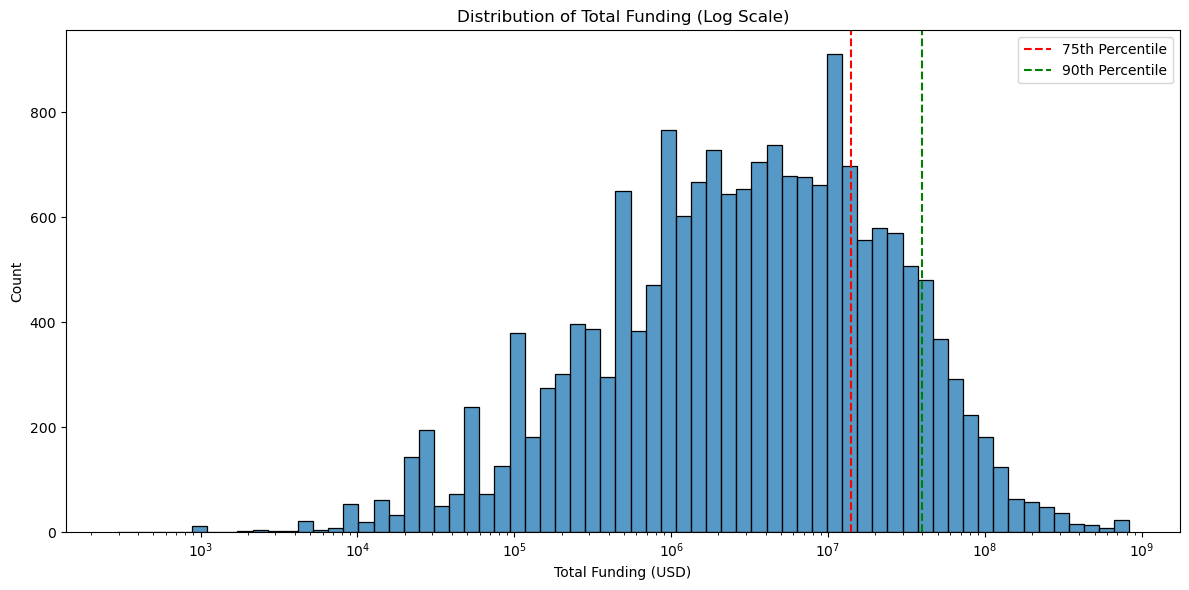

In [3]:
# Examine funding distribution for companies with funding data
funding_stats = companies_df['funding_total_usd'].describe()
print("\nFunding Statistics (USD):")
print(funding_stats)

# Calculate funding quartiles for companies with funding data
companies_with_funding = companies_df[companies_df['funding_total_usd'].notna()]
funding_quartiles = companies_with_funding['funding_total_usd'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
print("\nFunding Quartiles (USD):")
print(funding_quartiles)

# Visualize funding distribution (log scale due to high skew)
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_funding['funding_total_usd'], log_scale=True)
plt.title('Distribution of Total Funding (Log Scale)')
plt.xlabel('Total Funding (USD)')
plt.axvline(funding_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.axvline(funding_quartiles[0.9], color='g', linestyle='--', label='90th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('funding_distribution.png')
plt.show()


Company Age Statistics (years):
count   51613.00
mean        9.40
std         9.42
min         0.00
25%         5.00
50%         7.00
75%        10.00
max       114.00
Name: age, dtype: float64

Age Quartiles (years):
0.25    5.00
0.50    7.00
0.75   10.00
0.90   17.00
Name: age, dtype: float64


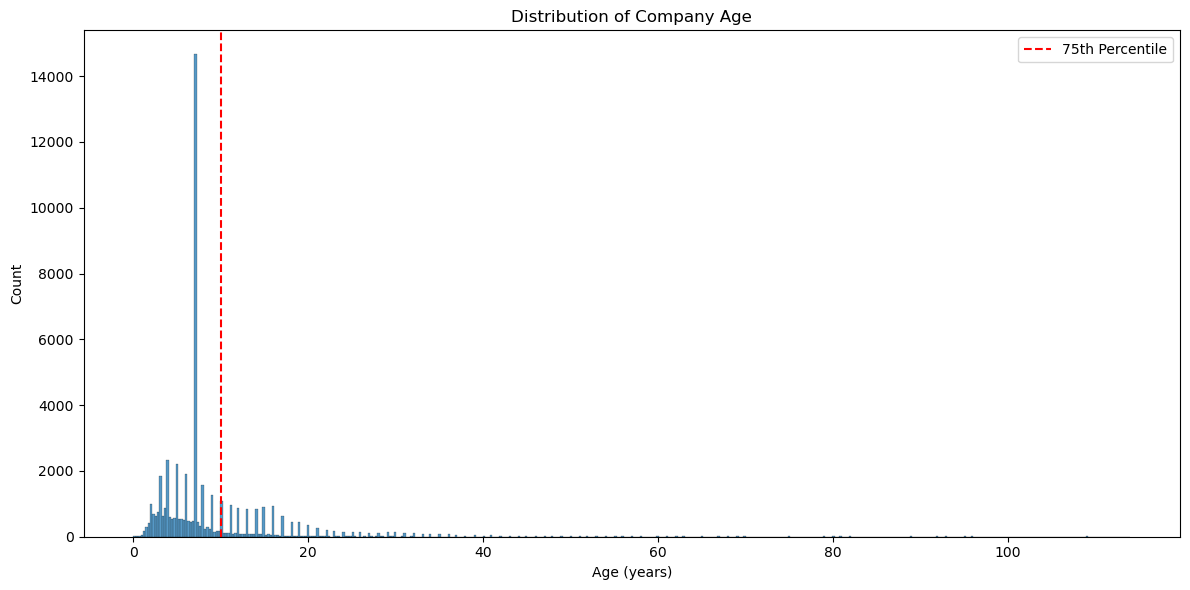

In [4]:
# Print age statistics
age_stats = companies_df['age'].describe()
print("\nCompany Age Statistics (years):")
print(age_stats)

# Calculate age quartiles
companies_with_age = companies_df[companies_df['age'].notna()]
age_quartiles = companies_with_age['age'].quantile([0.25, 0.5, 0.75, 0.9])
print("\nAge Quartiles (years):")
print(age_quartiles)

# Visualize age distribution
plt.figure(figsize=(12, 6))
sns.histplot(companies_with_age['age'])
plt.title('Distribution of Company Age')
plt.xlabel('Age (years)')
plt.axvline(age_quartiles[0.75], color='r', linestyle='--', label='75th Percentile')
plt.legend()
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()

In [5]:
# Define success metrics based on our analysis

# 1. Status-based success (acquired or IPO)
companies_df['success_status'] = companies_df['status'].apply(
    lambda x: 1 if x in ['acquired', 'ipo'] else 0
)

# Print status-based success distribution
print("\nStatus-based Success Distribution:")
status_success_counts = companies_df['success_status'].value_counts()
print(status_success_counts)
print(f"Percentage successful: {status_success_counts[1] / status_success_counts.sum() * 100:.2f}%")


Status-based Success Distribution:
success_status
0    45721
1     5892
Name: count, dtype: int64
Percentage successful: 11.42%



Composite Success Score Distribution:
success_score
0    34880
1     6593
2     4248
3     3310
4     1326
5     1256
Name: count, dtype: int64


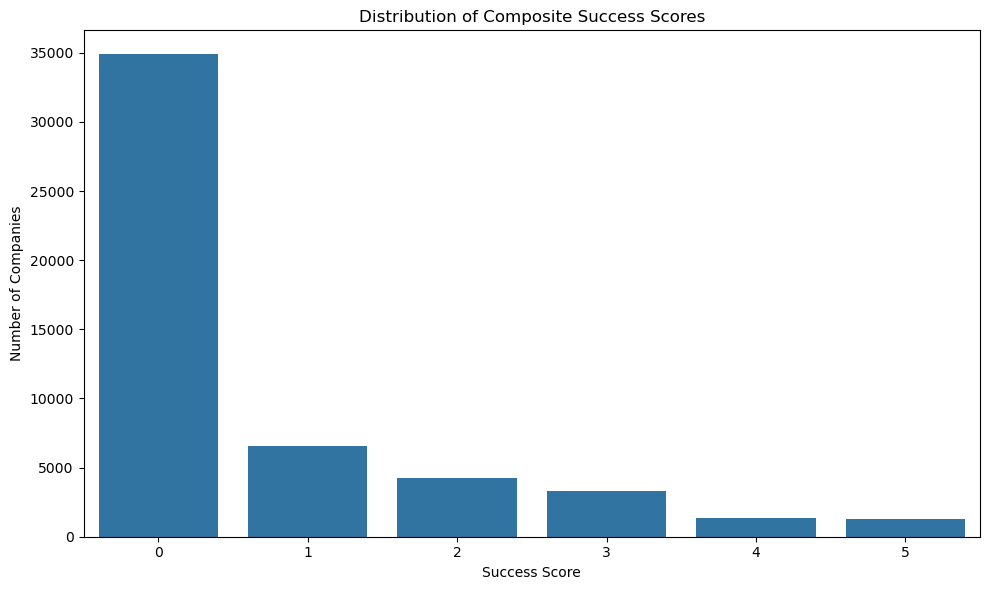

In [24]:
# Create a composite success metric combining status and age factors

# Define a function to assign a composite success score
def assign_composite_success(row):
    score = 0

    # Status-based component (highest weight)
    if row['status'] in ['acquired', 'ipo']:
        score += 3

    # Age-based component
    if pd.notna(row['age']):
        if row['age'] >= age_quartiles[0.9]:  # Top 25%
            score += 2
        elif age_quartiles[0.75] <= row['age'] <= age_quartiles[0.9]:  # Between 50th and 75th percentile
            score += 1

    return score

# Apply the composite scoring function
companies_df['success_score'] = companies_df.apply(assign_composite_success, axis=1)

# Print composite score distribution
print("\nComposite Success Score Distribution:")
score_counts = companies_df['success_score'].value_counts().sort_index()
print(score_counts)

# Visualize the score distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='success_score', data=companies_df, order=sorted(companies_df['success_score'].unique()))
plt.title('Distribution of Composite Success Scores')
plt.xlabel('Success Score')
plt.ylabel('Number of Companies')
plt.tight_layout()
plt.savefig('success_score_distribution.png')
plt.show()

In [25]:
# Binary success label (score of 1 or higher considered successful)
success_threshold = 1
companies_df['success_binary'] = (companies_df['success_score'] >= success_threshold).astype(int)

# Print binary success distribution
print("\nBinary Success Label Distribution based on the Composite Score:")
binary_counts = companies_df['success_binary'].value_counts()
print(binary_counts)
print(f"Percentage successful: {binary_counts[1] / binary_counts.sum() * 100:.2f}%")


Binary Success Label Distribution based on the Composite Score:
success_binary
0    34880
1    16733
Name: count, dtype: int64
Percentage successful: 32.42%


In [ ]:
#need to work on this cell

# Analyze success metrics by category_code to understand industry-specific patterns
# This can help validate our success definitions

# Get top 10 categories by count
top_categories = companies_df['category_code'].value_counts().head(10).index

# Calculate success rate by category
category_success = companies_df[companies_df['category_code'].isin(top_categories)].groupby('category_code')[
    ['success_binary', 'success_status']
].mean()

print("\nSuccess Rates by Top Categories:")
print(category_success.sort_values('success_binary', ascending=False))

# Visualize success rates by category
plt.figure(figsize=(12, 8))
category_success.sort_values('success_binary', ascending=False).plot(kind='bar')
plt.title('Success Rates by Category')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('category_success_rates.png')
plt.show()

KeyError: 'category_code'

In [28]:
# Save the dataset with success labels
output_file = 'usa_companies_with_success_labels.csv'
print(f"\nSaving dataset with success labels to {output_file}...")
companies_df.to_csv(output_file, index=False)
print(f"Saved {companies_df.shape[0]} rows with success metrics")


Saving dataset with success labels to usa_companies_with_success_labels.csv...
Saved 51613 rows with success metrics


In [ ]:
# Create a detailed report on the success metrics definition
report_content = """# Success Metrics Definition Report

## Overview
This report documents how success metrics were defined for the startup analysis project using the Crunchbase dataset. Multiple success metrics were created to capture different aspects of startup success, and a composite metric was developed to provide a more comprehensive measure.

## Success Metrics Defined

## Composite Success Metric

A composite success score was created by combining multiple factors:

- **Status Component**: 3 points for acquired/IPO companies
- **Age Component**:
             - 2 points for top 10%
             - 1 point for top 25%

### Success Score Distribution
{score_distribution}

### Binary Success Classification
- **Definition**: Companies with a success score ≥ {success_threshold}
- **Success Rate**: {binary_success_pct:.2f}% of companies classified as successful

## Industry-specific Success Patterns

Success rates vary significantly by industry category:

{category_success_rates}

## Conclusion

The composite success metric provides a balanced approach to measuring startup success, accounting for multiple dimensions while handling the challenge of missing data. The binary and multi-class labels derived from this metric will serve as target variables for predictive modeling in subsequent analysis steps.
""".format(
    funding_pct=len(companies_with_funding) / len(companies_df) * 100,
    age_pct=len(companies_with_age) / len(companies_df) * 100,
    status_success_pct=status_success_counts[1] / status_success_counts.sum() * 100 if 1 in status_success_counts else 0,
    score_distribution=score_counts.to_string(),
    success_threshold=success_threshold,
    binary_success_pct=binary_counts[1] / binary_counts.sum() * 100 if 1 in binary_counts else 0,
    #category_success_rates=category_success.sort_values('success_binary', ascending=False).to_string()
)

# Save the report
report_file = 'usa_success_metrics_report.md'
with open(report_file, 'w') as f:
    f.write(report_content)

print(f"Success metrics report saved to {report_file}")
print("\nSuccess metrics definition complete!")

KeyError: 'category_success_rates'